<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_v2_BETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v2.1.BETA.1
GREMLIN implemented in tensorflow

### Change log:
*   19Apr2019
 - added option to ignore gaps (now the default)
 - added option to initialize v and w from input
 - added function to score sequences (for design, ranking-mutations/homologys)
*   02Apr2019
 - fixed a few hard-coded values, to allow GREMLIN to work with any alphabet (binary, protein, rna etc)
*   22Jan2019
 - moving [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) to a seperate notebook
*   19Jan2019
 - in the past we found that optimizing V first, required less iterations for convergence. Since V can be computed exactly (assuming no W), we replace this first optimization step with a simple V initialization.
 - a few variables were renamed to be consistent with the c++ version
*   16Jan2019
 - updated how indices are handled (for easier/cleaner parsing)
 - minor speed up in how we symmetrize and zero the diagional of W
*   15Jan2019
 - LBFGS optimizer replaced with a modified version of the ADAM optimizer
 - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and accompanying [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)

See [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) for a stripped down version of this code (with no funky gap removal, sequence weight, etc). This is intented for educational purpose,  and could also be very useful for anyone trying to modify or improve the algorithm!


In [1]:
# ------------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42)
# ------------------------------------------------------------------
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------------
# The original MATLAB code for GREMLIN was written by Hetu Kamisetty
# ------------------------------------------------------------------

## External libraries

In [3]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.special import logsumexp
import pandas as pd

## Global parameters

In [4]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)

# map amino acids to integers (A->0, R->1, etc)
a2n = dict((a,n) for n,a in enumerate(alphabet))
aa2int = lambda x: a2n.get(x,a2n['-'])

## Parse MSA (Multiple Seq Alignment)

In [5]:
# from fasta
def parse_fasta(filename):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def filt_gaps(msa, gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  frac_gaps = np.mean((msa == states-1).astype(np.float),0)
  non_gaps = np.where(frac_gaps < gap_cutoff)[0]
  return msa[:,non_gaps], non_gaps

def get_eff(msa, eff_cutoff=0.8):
  '''compute effective weight for each sequence'''  
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  msa_w = (msa_sm >= eff_cutoff).astype(np.float)
  msa_w = 1.0/np.sum(msa_w,-1)
  return msa_w

def str2int(x):
  '''convert a list of strings into list of integers'''
  # Example: ["ACD","EFG"] -> [[0,4,3], [6,13,7]]
  if x.dtype.type is np.str_:
    if x.ndim == 0: return np.array([aa2int(aa) for aa in x])
    else: return np.array([[aa2int(aa) for aa in seq] for seq in x])
  else:
    return x
  
def split_train_test(seqs, frac_test=0.1):
  # shuffle data
  x = np.copy(seqs)
  np.random.shuffle(x[1:])

  # fraction of data used for testing
  split = int(len(x) * (1.0-frac_test))

  # split training/test datasets
  return x[:split], x[split:]

def mk_msa(seqs, gap_cutoff=0.5, eff_cutoff=0.8):
  '''converts list of sequences to MSA (Multiple Sequence Alignment)'''
  # =============================================================================
  # The function takes a list of sequences (strings) and returns a (dict)ionary
  # containing the following:
  # =============================================================================
  # BEFORE GAP REMOVAL
  # -----------------------------------------------------------------------------
  # msa_ori   msa
  # ncol_ori  number of columns
  # -----------------------------------------------------------------------------
  # AFTER GAP REMOVAL
  # By default, columns with ≥ 50% gaps are removed. This makes things a
  # little complicated, as we need to keep track of which positions were removed.
  # -----------------------------------------------------------------------------
  # msa       msa
  # ncol      number of columns
  # v_idx     index of positions kept
  # -----------------------------------------------------------------------------
  # weights   weight for each sequence (based on sequence identity)
  # nrow      number of rows (sequences)
  # neff      number of effective sequences sum(weights)
  # =============================================================================
  
  msa_ori = str2int(seqs)

  # remove positions with more than > 50% gaps
  msa, v_idx = filt_gaps(msa_ori)
  
  # compute effective weight for each sequence
  msa_weights = get_eff(msa, eff_cutoff)
    
  return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "nrow":msa.shape[0],
          "ncol":msa.shape[1],
          "ncol_ori":msa_ori.shape[1]}

## GREMLIN

In [6]:
# optimizer
def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  # adam optimizer
  # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
  # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
  # (b_fix=False) speeds up convergence for our case.
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

In [7]:
def GREMLIN(msa,
            opt_iter=100,
            opt_rate=1.0,
            batch_size=None,
            lam_v=0.01,
            lam_w=0.01,
            scale_lam_w=True,
            v=None,
            w=None,
            ignore_gap=True):
  
  '''fit params of MRF (Markov Random Field) given MSA (multiple sequence alignment)'''
  # ==========================================================================
  # this function takes a MSA (dict)ionary, from mk_msa() and returns a MRF
  # (dict)ionary containing the following:
  # ==========================================================================
  # len       full length
  # v_idx     index of positions (mapping back to full length)
  # v         2-body term
  # w         2-body term
  # ==========================================================================
  # WARNING: The mrf is over the msa after gap removal. "v_idx" and "len" are
  # important for mapping the MRF back to the original MSA.
  # ==========================================================================
  
  ########################################
  # SETUP COMPUTE GRAPH
  ########################################
  # reset tensorflow graph
  tf.reset_default_graph()
  
  # length of sequence
  ncol = msa["ncol"] 
  
  # input msa (multiple sequence alignment) 
  MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")
  
  # input msa weights
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
  
  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)
  
  if ignore_gap:
    ncat = states - 1
    NO_GAP = 1.0 - OH_MSA[...,-1] 
    OH_MSA = OH_MSA[...,:ncat]
    
  else:
    ncat = states
  
  ########################################
  # V: 1-body-term of the MRF
  ########################################
  V = tf.get_variable(name="V",
                          shape=[ncol,ncat],
                          initializer=tf.zeros_initializer)
  
  ########################################
  # W: 2-body-term of the MRF
  ########################################
  W_tmp = tf.get_variable(name="W",
                          shape=[ncol,ncat,ncol,ncat],
                          initializer=tf.zeros_initializer)  
  
  # symmetrize W
  W = W_tmp + tf.transpose(W_tmp,[2,3,0,1])
  
  # set diagonal to zero
  W = W * (1-np.eye(ncol))[:,None,:,None]

  ########################################
  # Pseudo-Log-Likelihood
  ########################################
  # V + W
  VW = V + tf.tensordot(OH_MSA,W,2)
  
  # hamiltonian
  H = tf.reduce_sum(OH_MSA*VW,-1)
  
  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,-1)

  PLL = H - Z
  if ignore_gap:
    PLL = PLL * NO_GAP  

  PLL = tf.reduce_sum(PLL,-1)  
  PLL = tf.reduce_sum(MSA_weights * PLL)/tf.reduce_sum(MSA_weights)

  ########################################
  # Regularization
  ########################################
  L2 = lambda x: tf.reduce_sum(tf.square(x))
  L2_V = lam_v * L2(V)
  L2_W = lam_w * L2(W) * 0.5
  
  if scale_lam_w:
    L2_W = L2_W * (ncol-1) * (states-1)
  
  ########################################
  # Loss Function
  ########################################
  # loss function to minimize
  loss = -PLL + (L2_V + L2_W) / msa["neff"]
  
  # optimizer
  opt = opt_adam(loss,"adam",lr=opt_rate)
  
  ########################################
  # Input Generator
  ########################################
  all_idx = np.arange(msa["nrow"])
  def feed(feed_all=False):
    if batch_size is None or feed_all:
      return {MSA:msa["msa"], MSA_weights:msa["weights"]}
    else:
      batch_idx = np.random.choice(all_idx,size=batch_size)
      return {MSA:msa["msa"][batch_idx], MSA_weights:msa["weights"][batch_idx]}
  
  ########################################
  # OPTIMIZE
  ########################################
  with tf.Session() as sess:
    
    # initialize variables V and W
    sess.run(tf.global_variables_initializer())

    # initialize V
    if v is None:
      oh_msa = np.eye(states)[msa["msa"]]
      if ignore_gap: oh_msa = oh_msa[...,:-1]
      
      pseudo_count = 0.01 * np.log(msa["neff"])
      f_v = np.einsum("nla,n->la",oh_msa,msa["weights"])
      V_ini = np.log(f_v + pseudo_count)
      if lam_v > 0:
        V_ini = V_ini - np.mean(V_ini,axis=-1,keepdims=True)
      sess.run(V.assign(V_ini))
      
    else:
      sess.run(V.assign(v))

    # initialize W
    if w is not None:
      sess.run(W_tmp.assign(w * 0.5))
      
    # compute loss across all data
    get_loss = lambda: np.round(sess.run(loss,feed(True)) * msa["neff"],2)

    print("starting",get_loss())      
    for i in range(opt_iter):
      sess.run(opt,feed())  
      if (i+1) % int(opt_iter/10) == 0:
        print("iter",(i+1),get_loss())
    
    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)
    
  ########################################
  # return MRF
  ########################################
  no_gap_states = states - 1
  mrf = {"v": V_[:,:no_gap_states],
         "w": W_[:,:no_gap_states,:,:no_gap_states],
         "v_idx": msa["v_idx"],
         "len": msa["ncol_ori"]}
  
  return mrf

## EXAMPLE

In [8]:
# download example fasta MSA
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [9]:
# ==========================================================================
# PREP MSA
# ==========================================================================
# parse fasta
headers, seqs = parse_fasta("4FAZA.fas")

train_seqs, test_seqs = split_train_test(seqs, frac_test=0.1)

# process input training sequences
msa = mk_msa(train_seqs, gap_cutoff=0.5, eff_cutoff=0.8)
# gap_cutoff=0.5 (positions with ≥ 50% gaps are removed)
# eff_cutoff=0.8 (sequences that share ≥ 80% sequence identity 
# are considered "effectively" a single sequence)

In [10]:
%%time
# ==========================================================================
# RUN GREMLIN
# ==========================================================================
mrf = GREMLIN(msa,lam_w=0.1)

# NOTE: lam_v (for one-body term) lam_w (for two-body term) can be used to regularize the model
#
# for contact prediction we find lam_w = 0.01 to be most optimial
# (even though it's technically overfitting on the data!)
# the overfitting is partly corrected by APC
#
# for design/scoring you may want to bump the lam_w to a higher value!


starting 45323.26
iter 10 40097.04
iter 20 39180.75
iter 30 38858.9
iter 40 38743.28
iter 50 38682.65
iter 60 38665.24
iter 70 38659.34
iter 80 38656.77
iter 90 38655.85
iter 100 38655.62
CPU times: user 1.82 s, sys: 603 ms, total: 2.42 s
Wall time: 9.49 s


## Use the MRF model to score "new" sequences
The source of "new" sequences maybe:
 - Test sequences (to check for overfitting)
 - Mutant sequences (to predict effects of mutations)
 - Newly sequenced genomes (to test fit to model, for annotation and homology search)
 
Note, high score means better fit to model. 

In [11]:
###############
## FUNCTIONS
###############
def score(mrf, x, recompute_z=False):
  x = str2int(x)

  # if length of sequence != length of model
  if x.shape[-1] != len(mrf["v_idx"]):
    x = x[...,mrf["v_idx"]]
  
  # one hot encode
  x = np.eye(states)[x] 
  
  # get non-gap positions
  no_gap = 1.0 - x[...,-1]
  
  # remove gap from one-hot-encoding
  x = x[...,:-1]
  
  # compute score
  vw = mrf["v"] + np.tensordot(x,mrf["w"],2)
  
  # ============================================================================================
  # Note, Z (the partition function) is a constant. In GREMLIN, V, W & Z are estimated using all
  # the original weighted input sequence(s). It is NOT recommended to recalculate Z with a 
  # different set of sequences. Given the common ERROR of recomputing Z, we include the option 
  # to do so, for comparison.
  # ============================================================================================
  h = np.sum(np.multiply(x,vw),axis=-1)
  if recompute_z:
    z = logsumexp(vw, axis=-1)
    return np.sum((h-z), axis=-1)
  else:
    return np.sum(h, axis=-1)

In [12]:
# provide a single sequence
print(seqs[0])
score(mrf,seqs[0])

PFAQIYLIEGRTEEQKRAVIEKVTQAMMEAVGAPKENVRVWIHDVPKENWGIGGVSAKALGR


286.66088777293

In [13]:
# provide multiple sequences
print(seqs[0:3])
score(mrf,seqs[0:3])

['PFAQIYLIEGRTEEQKRAVIEKVTQAMMEAVGAPKENVRVWIHDVPKENWGIGGVSAKALGR'
 'PIVQVVLIAGRTDEQKTRLIAGLTDSVVTVLGVGAESVRVFIKDIPNTEFGIGGATAASLGR'
 'SIIQVFFIAGRTDEQKERLIGALTDAAVKTIGIDRSDVRVILKDIPNTEYGIAGKTAKSLGR']


array([286.66088777, 257.17893655, 251.10126477])

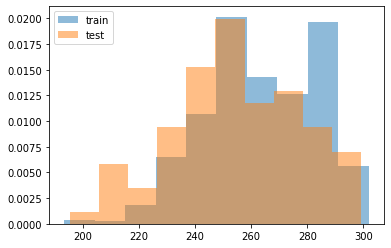

In [14]:
# provide all the sequences
train_scos = score(mrf, train_seqs)
test_scos = score(mrf, test_seqs)
plt.hist(train_scos,bins=10,alpha=0.5,density=True,label="train")
plt.hist(test_scos,bins=10,alpha=0.5,density=True,label="test")
plt.legend()
plt.show()

## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced from LxLx20x20 to LxL matrix (by taking the L2norm for each of the 20x20). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there are enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


In [15]:
###############
## FUNCTIONS
###############
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''convert MRF (Markov Random Field) to MTX (Matrix or Contact-map)'''
  
  # raw (l2norm of each 20x20 matrix)
  raw_sq = np.sqrt(np.sum(np.square(mrf["w"]),(1,3)))
  raw = squareform(raw_sq, checks=False)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True) * np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  i, j = np.triu_indices_from(raw_sq,k=1)
  mtx = {
         "i": mrf["v_idx"][i],
         "j": mrf["v_idx"][j],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc),
         "len": mrf["len"]
  }  
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  plt.figure(figsize=(15,5))
  for n, key in enumerate(["raw","apc","zscore"]):
    
    # create empty mtx
    m = np.ones((mtx["len"],mtx["len"])) * np.nan
    
    # populate
    m[mtx["i"],mtx["j"]] = mtx[key]
    m[mtx["j"],mtx["i"]] = m[mtx["i"],mtx["j"]]
    
    #plot
    plt.subplot(1,3,n+1)
    plt.title(key)
    if key == "zscore": plt.imshow(m, cmap='Blues', vmin=1, vmax=3)
    else: plt.imshow(m, cmap='Blues')
    plt.grid(False)
    
  plt.show()

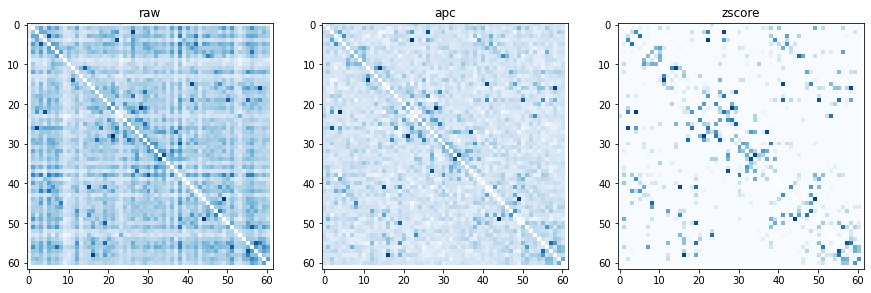

In [16]:
mtx = get_mtx(mrf)  
plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [17]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the index starts at 0
# - the "first" position is 0
# - in bioinformatics, the first position of a sequence is often "1"
#   for this index use i_aa and j_aa!

# adding amino acid to index+1
seq = seqs[0]
mtx["i_aa"] = [f"{seq[i]}_{i+1}" for i in mtx["i"]]
mtx["j_aa"] = [f"{seq[j]}_{j+1}" for j in mtx["j"]]

# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","raw","apc","zscore","i_aa","j_aa"])

# get contacts with sequence seperation > 5, sort
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("apc",ascending=False)

# show top 10
top.head(10)

,i,j,raw,apc,zscore,i_aa,j_aa
1056,21,28,0.396239,0.246706,2.875831,K_22,E_29
251,4,22,0.343012,0.243530,2.870875,I_5,V_23
881,16,58,0.362387,0.223808,2.835514,R_17,A_59
820,15,41,0.355480,0.215173,2.817182,K_16,I_42
142,2,26,0.365651,0.210584,2.806629,A_3,M_27
1278,27,37,0.289338,0.195313,2.766924,M_28,V_38
999,19,50,0.324115,0.184350,2.733434,I_20,G_51
488,8,45,0.272472,0.140721,2.543360,E_9,P_46
895,17,29,0.295545,0.139354,2.535524,A_18,A_30
990,19,41,0.293645,0.139352,2.535512,I_20,I_42


## Explore the MRF

In [18]:
###############
## FUNCTIONS
###############
def plot_pssm(v):
  mx = np.abs(v[np.where(v is not np.nan)]).max()
  # plot
  plt.figure(figsize=(v.shape[0]/4,v.shape[1]/4))
  plt.imshow(-v.T,cmap='bwr',vmin=-mx,vmax=mx)
  plt.yticks(np.arange(0,states-1))
  plt.grid(False)
  plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: alphabet[x]))
  plt.show()

def plot_v(mrf):  
  # prep
  v = np.ones((mrf["len"],mrf["v"].shape[1])) * np.nan
  v[mrf["v_idx"]] = mrf["v"]  
  plot_pssm(v)

def plot_w(mrf,i,j):
  i_idx = np.where(mrf["v_idx"] == i)[0][0]
  j_idx = np.where(mrf["v_idx"] == j)[0][0]
  w = mrf["w"][i_idx,:,j_idx,:]
  mx = np.abs(w).max()
  
  # plot
  plt.figure(figsize=(w.shape[0]/4,w.shape[1]/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(w.shape[0]))
  plt.yticks(np.arange(w.shape[1]))
  plt.grid(False)
  plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: alphabet[x])) 
  plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: alphabet[x]))
  plt.title(f"coupling matrix for {i} and {j}")
  plt.show()

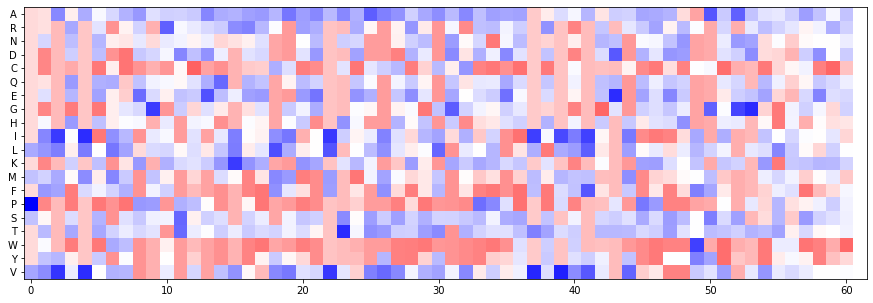

In [19]:
plot_v(mrf)

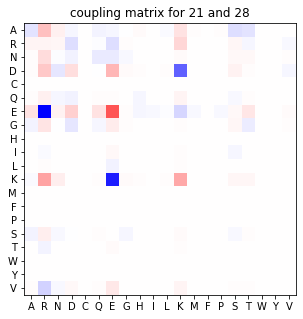

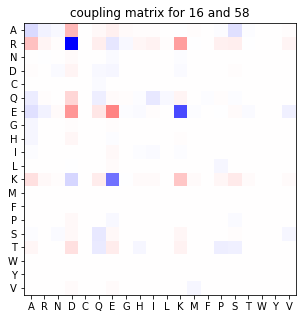

In [20]:
# plot top 2 coupling matrices
plot_w(mrf,21,28)
plot_w(mrf,16,58)

## EXAMPLE: ParDE
ParD and ParE are an example of a toxin and antitoxin pair of proteins. If the pair of proteins bind, the organism survives, if they do not, organism is screwed! Mike Laub created a library of mutants that targets this interface and their measured fitness (survivial). We'll see if we can use GREMLIN to predict these!

In [21]:
%%bash
# download the dataset
wget -q -nc -O ParDE.old.fas http://gremlin.bakerlab.org/fasta_cplx_sub/641_1413612817.fas
wget -q -nc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_A.csv
wget -q -nc https://files.ipd.uw.edu/krypton/design/Library_fitness_vs_parE3_replicate_B.csv

In [22]:
# load the alignment
parde_names, parde_seqs = parse_fasta("ParDE.old.fas")

# convert to msa
parde_msa = mk_msa(parde_seqs)

In [23]:
# fit mrf model
parde_mrf = GREMLIN(parde_msa)

starting 162282.22
iter 10 89082.37
iter 20 84431.68
iter 30 81059.75
iter 40 80239.13
iter 50 79914.95
iter 60 79801.52
iter 70 79760.49
iter 80 79743.3
iter 90 79736.68
iter 100 79733.63


In [24]:
parde_mtx = get_mtx(parde_mrf)

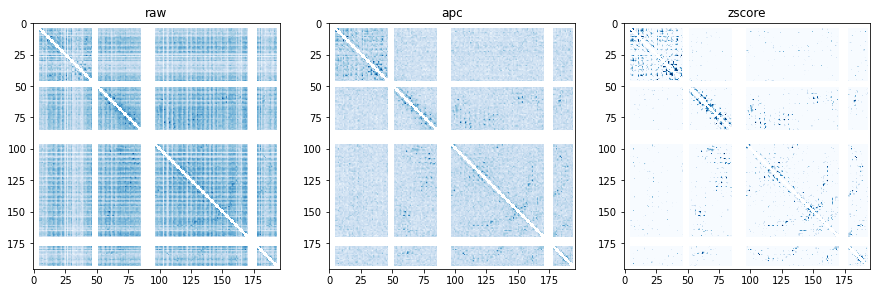

In [25]:
plot_mtx(parde_mtx)

In [26]:
# these are the positions that were mutated in the library
print([parde_seqs[0][n] for n in (58, 59, 60, 63)])

['L', 'W', 'D', 'K']


In [27]:
# load dataset
lib_a = np.loadtxt("Library_fitness_vs_parE3_replicate_A.csv",np.str,delimiter=",")
lib_b = np.loadtxt("Library_fitness_vs_parE3_replicate_B.csv",np.str,delimiter=",")

In [28]:
starting_seq = parde_msa["msa_ori"][0]

# lets parse the data
mut_seqs = []
mut_scos = []
for a, b in zip(lib_a,lib_b):
  mu_a, sc_a = a
  mu_b, sc_b = b
  
  muts = [aa2int(aa) for aa in mu_a]
  
  # starting sequence
  new_seq = np.copy(starting_seq)
  
  # mutate
  new_seq[58] = muts[0]
  new_seq[59] = muts[1]
  new_seq[60] = muts[2]
  new_seq[63] = muts[3]
    
  # save mutated sequence
  mut_seqs.append(new_seq)
  mut_scos.append([float(sc_a),float(sc_b)])
  
mut_seqs = np.array(mut_seqs)
mut_scos = np.array(mut_scos)
fitness = np.mean(mut_scos,-1)

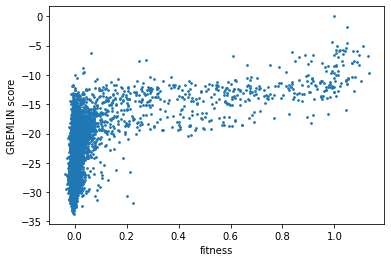

In [29]:
# compute score
pred_scos = score(parde_mrf,mut_seqs)

# substract wild-type
pred_scos -= score(parde_mrf,starting_seq)

# plot
plt.scatter(fitness,pred_scos,s=3)
plt.xlabel("fitness")
plt.ylabel("GREMLIN score")
plt.show()